In [850]:
# set variables
# Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]

NUM_DAYS = 100
INTERVAL = '1d'
SYMBOL = 'BTC-USD'
query = 'bitcoin'
subreddit = "CryptoCurrency"


INDICATORS = ['RSI', 'MACD']

In [763]:
#import libraries

import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay
from sklearn.linear_model import RidgeClassifierCV


from sktime.transformations.panel.rocket import Rocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.shapelets import ContractedShapeletTransform
from sktime.utils.slope_and_trend import _slope
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.classification.shapelet_based import MrSEQLClassifier

from pmaw import PushshiftAPI
import pandas as pd
import datetime

import redditcleaner
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata

from termcolor import cprint

In [764]:
nlp = spacy.load('en_core_web_sm')
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [765]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [766]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [767]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [768]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [769]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [770]:
def remove_urls(text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return(text)

In [771]:
def normalize_corpus(doc, url_removal=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    # remove urls
    if url_removal:
        doc = remove_urls(doc)
    # remove accented characters
    if accented_char_removal:
        doc = remove_accented_chars(doc)
    # expand contractions    
    if contraction_expansion:
        doc = expand_contractions(doc)
    # lowercase the text    
    if text_lower_case:
        doc = doc.lower()
    # remove extra newlines
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    # lemmatize text
    if text_lemmatization:
        doc = lemmatize_text(doc)
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        doc = remove_special_characters(doc, remove_digits=remove_digits)  
    # remove extra whitespace
    doc = re.sub(' +', ' ', doc)
    # remove stopwords
    if stopword_removal:
        doc = remove_stopwords(doc, is_lower_case=text_lower_case)
                    
    return doc

In [772]:
new_words = {
    'citron': -4.0,  
    'hidenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
    'tendies': 2.0,
    'town': 2.0,     
    'overvalued': -3.0,
    'undervalued': 3.0,
    'buy': 4.0,
    'sell': -4.0,
    'gone': -1.0,
    'gtfo': -1.7,
    'paper': -1.7,
    'bullish': 3.7,
    'bearish': -3.7,
    'bagholder': -1.7,
    'stonk': 1.9,
    'green': 1.9,
    'money': 1.2,
    'print': 2.2,
    'rocket': 2.2,
    'bull': 2.9,
    'bear': -2.9,
    'pumping': -1.0,
    'sus': -3.0,
    'offering': -2.3,
    'rip': -4.0,
    'downgrade': -3.0,
    'upgrade': 3.0,     
    'maintain': 1.0,          
    'pump': 1.9,
    'hot': 1.5,
    'drop': -2.5,
    'rebound': 1.5,  
    'crack': 2.5}

In [773]:
analyzer = SIA()
analyzer.lexicon.update(new_words)
api = PushshiftAPI()

In [774]:
#set timeframe

start = datetime.datetime(2021,10,11,0,0)
end = datetime.datetime(2022,1,20,0,0)

#start = (datetime.date.today()-datetime.timedelta(NUM_DAYS))
#end = datetime.datetime.today()

In [775]:
#download and rename dataframe

data = yf.download(SYMBOL, start, end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open', 'Adj Close':'adjclose'}, inplace=True)
data= data.reset_index()
data

[*********************100%***********************]  1 of 1 completed


Date         open         high          low        close  \
0   2021-10-10  3575.020508  3603.244873  3414.970947  3425.852783   
1   2021-10-11  3419.726807  3622.289551  3385.761719  3545.354004   
2   2021-10-12  3546.477783  3546.477783  3407.338135  3492.573242   
3   2021-10-13  3492.753662  3607.741699  3417.602051  3606.201660   
4   2021-10-14  3604.958984  3819.258545  3590.275146  3786.014160   
..         ...          ...          ...          ...          ...   
97  2022-01-15  3309.844238  3364.537842  3278.670898  3330.530762   
98  2022-01-16  3330.387207  3376.401123  3291.563721  3350.921875   
99  2022-01-17  3350.947266  3355.819336  3157.224121  3212.304932   
100 2022-01-18  3212.287598  3236.016113  3096.123535  3164.025146   
101 2022-01-19  3163.850342  3171.158447  3055.212402  3095.825928   

        adjclose       volume  
0    3425.852783  16171746693  
1    3545.354004  18579189588  
2    3492.573242  18109578443  
3    3606.201660  16211275589  
4    3786.014160  19443499909  
..           ...          ...  
97   3330.530762   9619999078  
98   3350.921875   9505934874  
99   3212.304932  12344309617  
100  3164.025146  13024154091  
101  3095.825928  13187424144  

[102 rows x 7 columns]

In [776]:
unix_start = []
for each in data['Date']:
    unix_start.append(datetime.datetime.strptime(str(each), "%Y-%m-%d %H:%M:%S").timestamp())

In [777]:
data['unix_start'] = unix_start

In [778]:
data = data.set_index(keys='Date')

In [779]:
# write dataframe to csv

data.to_csv(f'./current_data_{NUM_DAYS}_{SYMBOL}.csv', header=True, index=True, columns=list(data.axes[1]))

In [19]:
mean_pos = []
mean_neg = []
mean_neu = []
mean_comp = []
count = []
#limit=20
for i in range(len(data)):
    for retry in range(10):
        try:
            comments = api.search_comments(mem_safe=True, sort_type='score', q=query, subreddit=subreddit, after=int(data['unix_start'][i]), before=int(data['unix_start'][i]+24*60*60))
            cprint(f'{len(comments)} comments retrieved from Pushshift for index {i}')
            comments_df = pd.DataFrame(comments)
            comments_df = comments_df.body.to_frame()
        except AttributeError:
            continue
        except ValueError:
            continue
        except Exception:
            time.sleep(10)
            continue
        finally:
            if retry == 9:
                break
        break
    if retry == 9:
        mean_comp.append(np.nan)
        mean_pos.append(np.nan)
        mean_neg.append(np.nan)
        mean_neu.append(np.nan)
        count.append(np.nan)
        continue
    comments_df = comments_df[(comments_df.body != '[removed]') & (comments_df.body != '') & (comments_df.body != '[deleted]')].astype(str)
    count.append(len(comments_df))
    cprint(text = f'{len(comments_df)} comments added to dataframe', color= 'blue')
    cprint(text = 'Cleaning retrieved data...', color='blue')
    comments_df['clean_text'] = comments_df['body'].apply(lambda x: redditcleaner.clean(x))
    comments_df['clean_text'] = comments_df['clean_text'].apply(lambda x: normalize_corpus(x))
    cprint(text = 'Cleaning done', color='red')

    cprint(text = 'Calculating average sentiment...', color= 'blue')
    pos = []
    neg = []
    neu = []
    comp = []
    for sentence in comments_df['clean_text']:
        vs = SIA().polarity_scores(sentence)
        comp.append(vs['compound'])
        pos.append(vs['pos'])
        neg.append(vs['neg'])
        neu.append(vs['neu'])

    mean_pos.append(np.mean(pos))
    mean_neg.append(np.mean(neg))
    mean_neu.append(np.mean(neu))
    mean_comp.append(np.mean(comp))
    cprint(text = f'Done for index {i}', color= 'red')
    if i == len(data)-1:
        cprint(text='   Process complete!   ', color='green', on_color='on_grey')

INFO:pmaw.Cache:Response cache key: d9004e7025e5c0d0708cdf86a2ec0f17
INFO:pmaw.PushshiftAPIBase:418 result(s) available in Pushshift
INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 10 - Batches: 1 - Items Remaining: 0
418 comments retrieved from Pushshift for index 0
418 comments added to dataframe
Cleaning retrieved data...
Cleaning done
Calculating average sentiment...
Done for index 0
INFO:pmaw.Cache:Response cache key: 63285325843a78d8a7921fd4f8a46ee5
INFO:pmaw.PushshiftAPIBase:481 result(s) available in Pushshift
INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 83.33% - Requests: 12 - Batches: 2 - Items Remaining: 0
481 comments retrieved from Pushshift for index 1
481 comments added to dataframe
Cleaning retrieved data...
Cleaning done
Calculating average sentiment...
Done for index 1
INFO:pmaw.Cache:Response cache key: cf53f5bc5a1f292bc83f2493cb1c2a13
INFO:pmaw.PushshiftAPIBase:349 result(s) available in Pushshift
INFO:pmaw.PushshiftAPIBase:Total:: Success R

In [ ]:
len(mean_neu) == len(mean_pos) == len(data) == len(data) == len(data)

True

In [ ]:
senti = {'mean_pos':mean_pos, 'mean_neg':mean_neg, 'mean_comp':mean_comp, 'mean_neu':mean_neu, 'count':count}
senti = pd.DataFrame(senti)
senti

mean_pos  mean_neg  mean_comp  mean_neu  count
0   0.188600  0.217200   0.192280  0.594200      5
1   0.221800  0.038000   0.463400  0.740000      5
2   0.110500  0.104500   0.270225  0.785000      4
3   0.193545  0.100818   0.217845  0.705636     11
4   0.114571  0.146857  -0.078114  0.738571      7
..       ...       ...        ...       ...    ...
65  0.089579  0.066895   0.078911  0.843526     19
66  0.209080  0.082200   0.182672  0.708720     25
67  0.150571  0.060619   0.244952  0.788810     21
68  0.139120  0.084360   0.127684  0.776520     25
69  0.130536  0.146179  -0.023289  0.723286     28

[70 rows x 5 columns]

In [ ]:
# write sentiments to csv

senti.to_csv(f'./senti_{NUM_DAYS}_{SYMBOL}.csv', header=True, index=True, columns=list(senti.axes[1]))

In [851]:
# read sentiments from csv

senti = pd.read_csv(f'senti_{NUM_DAYS}_{SYMBOL}.csv', index_col=False)

In [852]:
senti.drop(columns=['Unnamed: 0', 'mean_comp', 'mean_neu'], inplace=True)

In [853]:
senti 

mean_pos  mean_neg  count
0    0.182265  0.098628   1203
1    0.180098  0.086197   1818
2    0.165146  0.097838   1757
3    0.177788  0.104650   1378
4    0.183991  0.098177   1364
..        ...       ...    ...
97   0.176549  0.095359    832
98   0.172163  0.121972   1054
99   0.181017  0.099893    719
100  0.172249  0.099551    900
101  0.172717  0.094028   1052

[102 rows x 3 columns]

In [854]:
senti['count'].mean()

1127.921568627451

In [855]:
senti['count'].sum()

115048

In [783]:
# read dataframe from csv

data = pd.read_csv(f'current_data_{NUM_DAYS}_{SYMBOL}.csv')
data.drop(columns=['unix_start'], inplace=True)

In [784]:
data =pd.concat([data, senti], axis=1)

In [785]:
data = data.set_index('Date')

<AxesSubplot:xlabel='Date'>

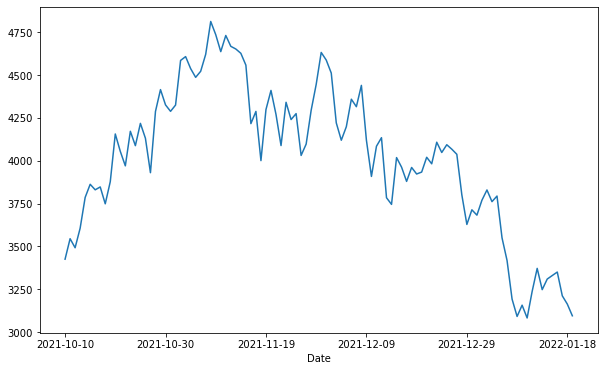

In [786]:
data['close'].plot(figsize=(10,6))

In [787]:
# smoothing close

data['close'] = data['close'].ewm(0.65).mean()

<AxesSubplot:xlabel='Date'>

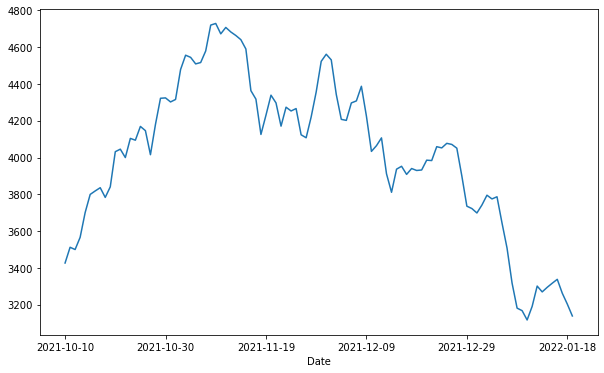

In [788]:
data['close'].plot(figsize=(10,6))

In [789]:
len(data)

102

In [790]:
# add exponential moving averages

data['ema50'] = data['close'].ewm(span=50, adjust=False).mean()
data['ema21'] = data['close'].ewm(span=21, adjust=False).mean()
data['ema15'] = data['close'].ewm(span=15, adjust=False).mean()
data['ema5'] = data['close'].ewm(span=5, adjust=False).mean()

<AxesSubplot:xlabel='Date'>

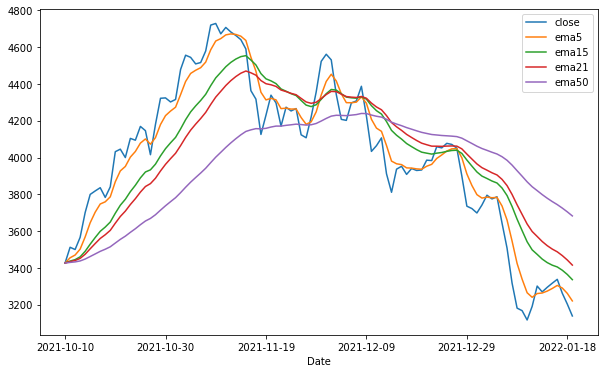

In [791]:
data[['close', 'ema5', 'ema15', 'ema21', 'ema50']].plot(figsize=(10,6))

In [792]:
# add normalized volume

#data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

In [793]:
# delete OHLC columns
 
del (data['open'])
del (data['high'])
del (data['low'])
# del (data['volume'])
del (data['adjclose'])

In [794]:
data

close       volume  mean_pos  mean_neg  count        ema50  \
Date                                                                           
2021-10-10  3425.852783  16171746693  0.176823  0.089278    418  3425.852783   
2021-10-11  3511.581920  18579189588  0.176960  0.092780    481  3429.214710   
2021-10-12  3499.311351  18109578443  0.166470  0.077347    349  3431.963598   
2021-10-13  3565.692028  16211275589  0.182520  0.085402    435  3437.207850   
2021-10-14  3700.499566  19443499909  0.182446  0.089833    372  3447.533015   
...                 ...          ...       ...       ...    ...          ...   
2022-01-15  3316.056411   9619999078  0.188397  0.078520    375  3760.348187   
2022-01-16  3337.186995   9505934874  0.192622  0.069974    389  3743.753630   
2022-01-17  3261.500896  12344309617  0.194787  0.067309    385  3724.841758   
2022-01-18  3202.424684  13024154091  0.192392  0.063460    452  3704.354814   
2022-01-19  3137.819377  13187424144  0.192515  0.066168    423  3682.137738   

                  ema21        ema15         ema5  
Date                                               
2021-10-10  3425.852783  3425.852783  3425.852783  
2021-10-11  3433.646341  3436.568925  3454.429162  
2021-10-12  3439.615887  3444.411728  3469.389892  
2021-10-13  3451.077355  3459.571766  3501.490604  
2021-10-14  3473.752101  3489.687741  3567.826924  
...                 ...          ...          ...  
2022-01-15  3501.816358  3414.199413  3287.438002  
2022-01-16  3486.850053  3404.572860  3304.021000  
2022-01-17  3466.363766  3386.688865  3289.847632  
2022-01-18  3442.369304  3363.655842  3260.706649  
2022-01-19  3414.682947  3335.426284  3219.744225  

[102 rows x 9 columns]

In [795]:
# add 'prediction' column <------ target variable

prediction = (data.shift(-1)['close']>=data['close'])
prediction = prediction.iloc[:-1]
data['pred'] = prediction.astype(int)

In [796]:
data

close       volume  mean_pos  mean_neg  count        ema50  \
Date                                                                           
2021-10-10  3425.852783  16171746693  0.176823  0.089278    418  3425.852783   
2021-10-11  3511.581920  18579189588  0.176960  0.092780    481  3429.214710   
2021-10-12  3499.311351  18109578443  0.166470  0.077347    349  3431.963598   
2021-10-13  3565.692028  16211275589  0.182520  0.085402    435  3437.207850   
2021-10-14  3700.499566  19443499909  0.182446  0.089833    372  3447.533015   
...                 ...          ...       ...       ...    ...          ...   
2022-01-15  3316.056411   9619999078  0.188397  0.078520    375  3760.348187   
2022-01-16  3337.186995   9505934874  0.192622  0.069974    389  3743.753630   
2022-01-17  3261.500896  12344309617  0.194787  0.067309    385  3724.841758   
2022-01-18  3202.424684  13024154091  0.192392  0.063460    452  3704.354814   
2022-01-19  3137.819377  13187424144  0.192515  0.066168    423  3682.137738   

                  ema21        ema15         ema5  pred  
Date                                                     
2021-10-10  3425.852783  3425.852783  3425.852783   1.0  
2021-10-11  3433.646341  3436.568925  3454.429162   0.0  
2021-10-12  3439.615887  3444.411728  3469.389892   1.0  
2021-10-13  3451.077355  3459.571766  3501.490604   1.0  
2021-10-14  3473.752101  3489.687741  3567.826924   1.0  
...                 ...          ...          ...   ...  
2022-01-15  3501.816358  3414.199413  3287.438002   1.0  
2022-01-16  3486.850053  3404.572860  3304.021000   0.0  
2022-01-17  3466.363766  3386.688865  3289.847632   0.0  
2022-01-18  3442.369304  3363.655842  3260.706649   0.0  
2022-01-19  3414.682947  3335.426284  3219.744225   NaN  

[102 rows x 10 columns]

In [797]:
#Fourier transform the sentiment score
# close_fft = np.fft.fft(np.asarray(data['mean_comp'].tolist()))
# fft_df = pd.DataFrame({'fft':close_fft})
# fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
# fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
# fft_list = np.asarray(fft_df['fft'].tolist())
# for num_ in [5, 10, 15, 20]:
#     fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
#     data['mean_comp fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

#Fourier transform the sentiment score
close_fft = np.fft.fft(np.asarray(data['mean_pos'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    data['mean_pos fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

#Fourier transform the sentiment score
close_fft = np.fft.fft(np.asarray(data['mean_neg'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    data['mean_neg fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

In [798]:
# data['mean_comp fourier 5'] = data['mean_comp fourier 5'].apply(lambda x: x.real)
# data['mean_comp fourier 10'] = data['mean_comp fourier 10'].apply(lambda x: x.real)
# data['mean_comp fourier 15'] = data['mean_comp fourier 15'].apply(lambda x: x.real)
# data['mean_comp fourier 20'] = data['mean_comp fourier 20'].apply(lambda x: x.real)

data['mean_pos fourier 5'] = data['mean_pos fourier 5'].apply(lambda x: x.real)
data['mean_pos fourier 10'] = data['mean_pos fourier 10'].apply(lambda x: x.real)
data['mean_pos fourier 15'] = data['mean_pos fourier 15'].apply(lambda x: x.real)
data['mean_pos fourier 20'] = data['mean_pos fourier 20'].apply(lambda x: x.real)

data['mean_neg fourier 5'] = data['mean_neg fourier 5'].apply(lambda x: x.real)
data['mean_neg fourier 10'] = data['mean_neg fourier 10'].apply(lambda x: x.real)
data['mean_neg fourier 15'] = data['mean_neg fourier 15'].apply(lambda x: x.real)
data['mean_neg fourier 20'] = data['mean_neg fourier 20'].apply(lambda x: x.real)


In [799]:
normalized_data = (data-data.min())/(data.max()-data.min())

In [800]:
normalized_data

close    volume  mean_pos  mean_neg     count     ema50  \
Date                                                                     
2021-10-10  0.192034  0.230069  0.382181  0.785039  0.554987  0.000000   
2021-10-11  0.245173  0.313162  0.385023  0.879122  0.716113  0.004131   
2021-10-12  0.237567  0.296953  0.168237  0.464522  0.378517  0.007509   
2021-10-13  0.278713  0.231434  0.499900  0.680933  0.598465  0.013953   
2021-10-14  0.362273  0.342993  0.498385  0.799971  0.437340  0.026640   
...              ...       ...       ...       ...       ...       ...   
2022-01-15  0.123977  0.003937  0.621363  0.496042  0.445013  0.411022   
2022-01-16  0.137074  0.000000  0.708667  0.266464  0.480818  0.390631   
2022-01-17  0.090160  0.097966  0.753405  0.194864  0.470588  0.367393   
2022-01-18  0.053542  0.121431  0.703904  0.091464  0.641944  0.342219   
2022-01-19  0.013496  0.127066  0.706461  0.164205  0.567775  0.314919   

               ema21     ema15      ema5  pred  mean_pos fourier 5  \
Date                                                                 
2021-10-10  0.010577  0.074198  0.141875   1.0            0.693844   
2021-10-11  0.017957  0.082991  0.161546   0.0            0.600134   
2021-10-12  0.023610  0.089426  0.171844   1.0            0.502637   
2021-10-13  0.034464  0.101865  0.193940   1.0            0.405335   
2021-10-14  0.055936  0.126576  0.239603   1.0            0.312138   
...              ...       ...       ...   ...                 ...   
2022-01-15  0.082511  0.064636  0.046597   1.0            0.989350   
2022-01-16  0.068339  0.056737  0.058012   0.0            0.961321   
2022-01-17  0.048939  0.042063  0.048256   0.0            0.916139   
2022-01-18  0.026218  0.023163  0.028197   0.0            0.854987   
2022-01-19  0.000000  0.000000  0.000000   NaN            0.779941   

            mean_pos fourier 10  mean_pos fourier 15  mean_pos fourier 20  \
Date                                                                        
2021-10-10             0.552035             0.404374             0.359367   
2021-10-11             0.439146             0.234294             0.106498   
2021-10-12             0.356104             0.201213             0.117850   
2021-10-13             0.305841             0.278151             0.320409   
2021-10-14             0.282560             0.380224             0.508438   
...                         ...                  ...                  ...   
2022-01-15             1.000000             0.862202             0.685723   
2022-01-16             0.984477             0.973527             0.832985   
2022-01-17             0.918629             1.000000             1.000000   
2022-01-18             0.811996             0.886658             0.993386   
2022-01-19             0.682662             0.657148             0.735438   

            mean_neg fourier 5  mean_neg fourier 10  mean_neg fourier 15  \
Date                                                                       
2021-10-10            0.348147             0.408399             0.396293   
2021-10-11            0.411248             0.499219             0.562140   
2021-10-12            0.470564             0.569815             0.637646   
2021-10-13            0.523916             0.615149             0.600158   
2021-10-14            0.569556             0.633702             0.486648   
...                        ...                  ...                  ...   
2022-01-15            0.065679             0.004105             0.038363   
2022-01-16            0.109395             0.041977             0.006074   
2022-01-17            0.161803             0.110791             0.000000   
2022-01-18            0.220756             0.202503             0.062640   
2022-01-19            0.283761             0.305794             0.206482   

            mean_neg fourier 20  
Date                             
2021-10-10             0.527986  
2021-10-11             0.788594  
2021-10-12    

<AxesSubplot:>

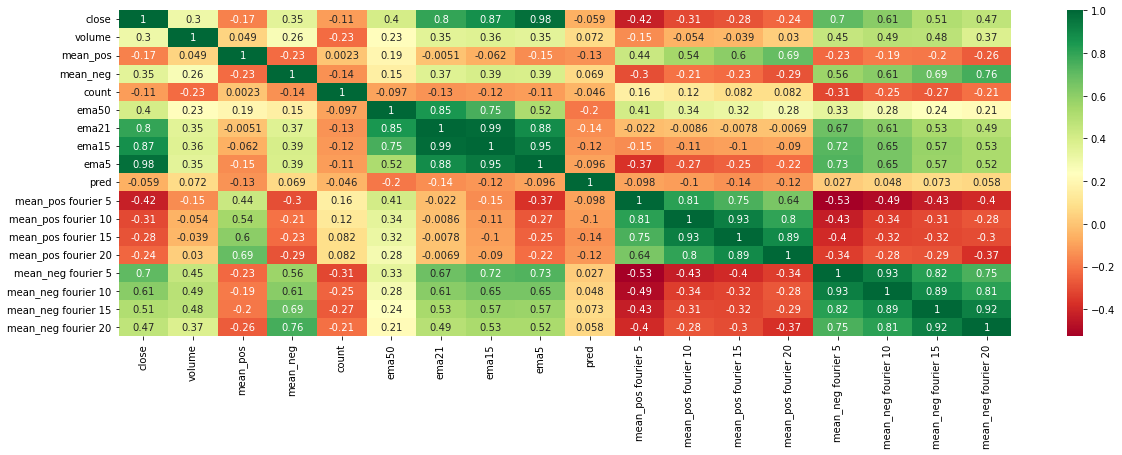

In [801]:
# plot the correlation of the features

corrmat = normalized_data.corr()
plt.figure(figsize=(20,6))
sns.heatmap(corrmat, annot=True, cmap='RdYlGn')

In [802]:
tmp = normalized_data

<AxesSubplot:xlabel='Date'>

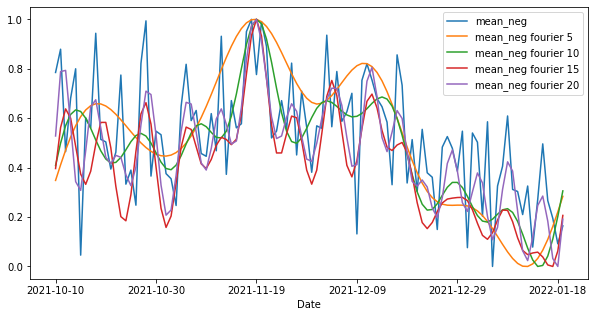

In [803]:
tmp[['mean_neg','mean_neg fourier 5','mean_neg fourier 10','mean_neg fourier 15','mean_neg fourier 20']].plot(figsize=(10,5))

<AxesSubplot:xlabel='Date'>

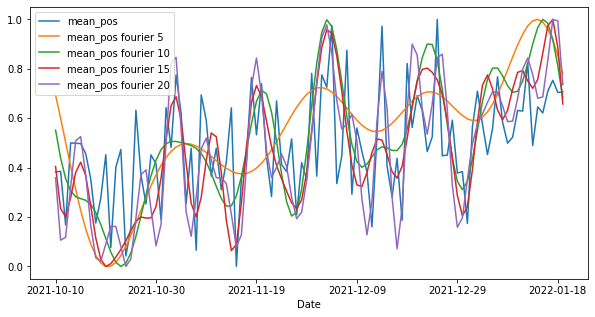

In [804]:
tmp[['mean_pos','mean_pos fourier 5','mean_pos fourier 10','mean_pos fourier 15','mean_pos fourier 20']].plot(figsize=(10,5))

In [843]:
tmp[['close', 'count']].plot(figsize=(10,5))

KeyError: "['close'] not in index"

In [806]:
normalized_data['pred'].value_counts(normalize=True)

0.0    0.50495
1.0    0.49505
Name: pred, dtype: float64

In [807]:
normalized_data

close    volume  mean_pos  mean_neg     count     ema50  \
Date                                                                     
2021-10-10  0.192034  0.230069  0.382181  0.785039  0.554987  0.000000   
2021-10-11  0.245173  0.313162  0.385023  0.879122  0.716113  0.004131   
2021-10-12  0.237567  0.296953  0.168237  0.464522  0.378517  0.007509   
2021-10-13  0.278713  0.231434  0.499900  0.680933  0.598465  0.013953   
2021-10-14  0.362273  0.342993  0.498385  0.799971  0.437340  0.026640   
...              ...       ...       ...       ...       ...       ...   
2022-01-15  0.123977  0.003937  0.621363  0.496042  0.445013  0.411022   
2022-01-16  0.137074  0.000000  0.708667  0.266464  0.480818  0.390631   
2022-01-17  0.090160  0.097966  0.753405  0.194864  0.470588  0.367393   
2022-01-18  0.053542  0.121431  0.703904  0.091464  0.641944  0.342219   
2022-01-19  0.013496  0.127066  0.706461  0.164205  0.567775  0.314919   

               ema21     ema15      ema5  pred  mean_pos fourier 5  \
Date                                                                 
2021-10-10  0.010577  0.074198  0.141875   1.0            0.693844   
2021-10-11  0.017957  0.082991  0.161546   0.0            0.600134   
2021-10-12  0.023610  0.089426  0.171844   1.0            0.502637   
2021-10-13  0.034464  0.101865  0.193940   1.0            0.405335   
2021-10-14  0.055936  0.126576  0.239603   1.0            0.312138   
...              ...       ...       ...   ...                 ...   
2022-01-15  0.082511  0.064636  0.046597   1.0            0.989350   
2022-01-16  0.068339  0.056737  0.058012   0.0            0.961321   
2022-01-17  0.048939  0.042063  0.048256   0.0            0.916139   
2022-01-18  0.026218  0.023163  0.028197   0.0            0.854987   
2022-01-19  0.000000  0.000000  0.000000   NaN            0.779941   

            mean_pos fourier 10  mean_pos fourier 15  mean_pos fourier 20  \
Date                                                                        
2021-10-10             0.552035             0.404374             0.359367   
2021-10-11             0.439146             0.234294             0.106498   
2021-10-12             0.356104             0.201213             0.117850   
2021-10-13             0.305841             0.278151             0.320409   
2021-10-14             0.282560             0.380224             0.508438   
...                         ...                  ...                  ...   
2022-01-15             1.000000             0.862202             0.685723   
2022-01-16             0.984477             0.973527             0.832985   
2022-01-17             0.918629             1.000000             1.000000   
2022-01-18             0.811996             0.886658             0.993386   
2022-01-19             0.682662             0.657148             0.735438   

            mean_neg fourier 5  mean_neg fourier 10  mean_neg fourier 15  \
Date                                                                       
2021-10-10            0.348147             0.408399             0.396293   
2021-10-11            0.411248             0.499219             0.562140   
2021-10-12            0.470564             0.569815             0.637646   
2021-10-13            0.523916             0.615149             0.600158   
2021-10-14            0.569556             0.633702             0.486648   
...                        ...                  ...                  ...   
2022-01-15            0.065679             0.004105             0.038363   
2022-01-16            0.109395             0.041977             0.006074   
2022-01-17            0.161803             0.110791             0.000000   
2022-01-18            0.220756             0.202503             0.062640   
2022-01-19            0.283761             0.305794             0.206482   

            mean_neg fourier 20  
Date                             
2021-10-10             0.527986  
2021-10-11             0.788594  
2021-10-12    

In [808]:
# delete 'close' column

del (normalized_data['close'])

In [809]:
# set aside end-frame data for prediction later

live_pred_data = normalized_data.iloc[-1:]
live_real = live_pred_data['pred']
live_pred_data = live_pred_data.drop(['pred'], axis=1)
live_pred_data

volume  mean_pos  mean_neg     count     ema50  ema21  ema15  \
Date                                                                         
2022-01-19  0.127066  0.706461  0.164205  0.567775  0.314919    0.0    0.0   

            ema5  mean_pos fourier 5  mean_pos fourier 10  \
Date                                                        
2022-01-19   0.0            0.779941             0.682662   

            mean_pos fourier 15  mean_pos fourier 20  mean_neg fourier 5  \
Date                                                                       
2022-01-19             0.657148             0.735438            0.283761   

            mean_neg fourier 10  mean_neg fourier 15  mean_neg fourier 20  
Date                                                                       
2022-01-19             0.305794             0.206482             0.191289

In [810]:
# drop all rows with null values

normalized_data = normalized_data.dropna()

In [811]:
normalized_data


volume  mean_pos  mean_neg     count     ema50     ema21  \
Date                                                                     
2021-10-10  0.230069  0.382181  0.785039  0.554987  0.000000  0.010577   
2021-10-11  0.313162  0.385023  0.879122  0.716113  0.004131  0.017957   
2021-10-12  0.296953  0.168237  0.464522  0.378517  0.007509  0.023610   
2021-10-13  0.231434  0.499900  0.680933  0.598465  0.013953  0.034464   
2021-10-14  0.342993  0.498385  0.799971  0.437340  0.026640  0.055936   
...              ...       ...       ...       ...       ...       ...   
2022-01-14  0.140027  0.645633  0.271268  0.554987  0.433306  0.100102   
2022-01-15  0.003937  0.621363  0.496042  0.445013  0.411022  0.082511   
2022-01-16  0.000000  0.708667  0.266464  0.480818  0.390631  0.068339   
2022-01-17  0.097966  0.753405  0.194864  0.470588  0.367393  0.048939   
2022-01-18  0.121431  0.703904  0.091464  0.641944  0.342219  0.026218   

               ema15      ema5  pred  mean_pos fourier 5  mean_pos fourier 10  \
Date                                                                            
2021-10-10  0.074198  0.141875   1.0            0.693844             0.552035   
2021-10-11  0.082991  0.161546   0.0            0.600134             0.439146   
2021-10-12  0.089426  0.171844   1.0            0.502637             0.356104   
2021-10-13  0.101865  0.193940   1.0            0.405335             0.305841   
2021-10-14  0.126576  0.239603   1.0            0.312138             0.282560   
...              ...       ...   ...                 ...                  ...   
2022-01-14  0.076140  0.036747   1.0            1.000000             0.967303   
2022-01-15  0.064636  0.046597   1.0            0.989350             1.000000   
2022-01-16  0.056737  0.058012   0.0            0.961321             0.984477   
2022-01-17  0.042063  0.048256   0.0            0.916139             0.918629   
2022-01-18  0.023163  0.028197   0.0            0.854987             0.811996   

            mean_pos fourier 15  mean_pos fourier 20  mean_neg fourier 5  \
Date                                                                       
2021-10-10             0.404374             0.359367            0.348147   
2021-10-11             0.234294             0.106498            0.411248   
2021-10-12             0.201213             0.117850            0.470564   
2021-10-13             0.278151             0.320409            0.523916   
2021-10-14             0.380224             0.508438            0.569556   
...                         ...                  ...                 ...   
2022-01-14             0.756817             0.680834            0.032302   
2022-01-15             0.862202             0.685723            0.065679   
2022-01-16             0.973527             0.832985            0.109395   
2022-01-17             1.000000             1.000000            0.161803   
2022-01-18             0.886658             0.993386            0.220756   

            mean_neg fourier 10  mean_neg fourier 15  mean_neg fourier 20  
Date                                                                       
2021-10-10             0.408399             0.396293             0.527986  
2021-10-11             0.499219             0.562140             0.788594  
2021-10-12             0.569815             0.637646             0.793447  
2021-10-13             0.615149             0.600158             0.572480  
2021-10-14             0.633702             0.486648             0.343240  
...                         ...                  ...                  ...  
2022-01-14             0.000000             0.057901             0.246740  
2022-01-15             0.004105             0.038363             0.284831  
2022-01-16             0.041977             0.006074             0.183540  
2022-01-17             0.110791             0.000000             0.032046  
2022-01-18             0.202503             0.062640             0.000000  

[101 rows x 17 colu

<AxesSubplot:>

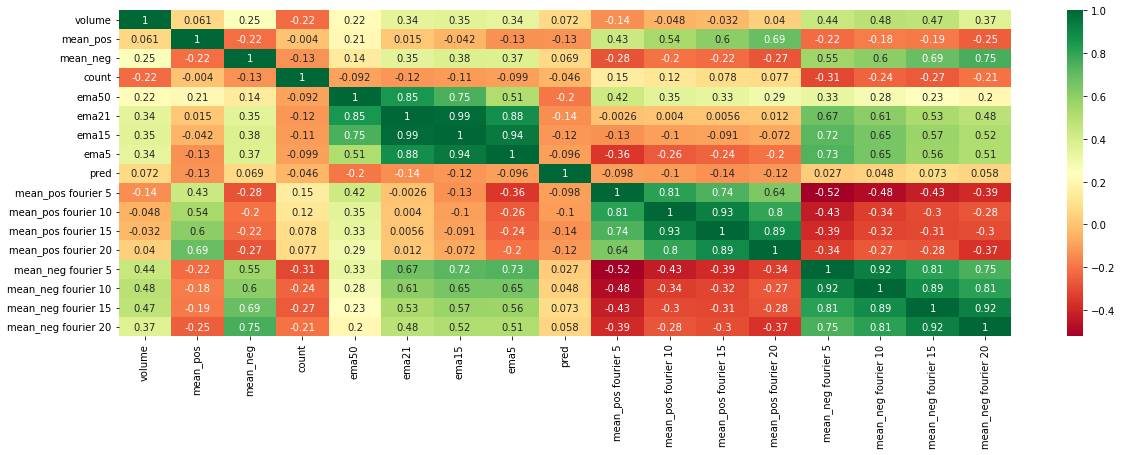

In [812]:
# plot the correlation of the features

corrmat = normalized_data.corr()
plt.figure(figsize=(20,6))
sns.heatmap(corrmat, annot=True, cmap='RdYlGn')

# Train-Test Split

In [813]:
# define dependant and independant variables
 
y = normalized_data[['pred']]
X = normalized_data.drop(['pred'], axis=1)

In [814]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=False)

In [815]:
print(len(X_train))
print(len(X_test))

80
21


# SKLearn Algorithms

## Random Forest Classifer

###  Baseline

In [816]:
# train baseline random forest classifier

rf_clf = RandomForestClassifier(n_estimators=20000, random_state=1, n_jobs=-1)

rf_clf = rf_clf.fit(X_train, y_train.values.ravel())

In [817]:
# evaluate baseline classifier
 
y_pred = rf_clf.predict(X_test)
print('Baseline Acc = ', accuracy_score(y_test, y_pred))
print('Baseline f1 score = ', f1_score(y_test, y_pred))

Baseline Acc =  0.6190476190476191
Baseline f1 score =  0.3333333333333333


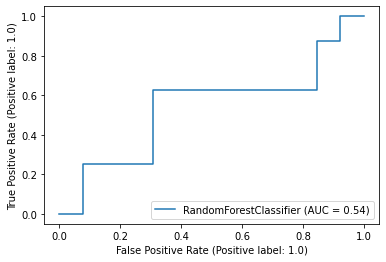

In [818]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=ax)
plt.show()

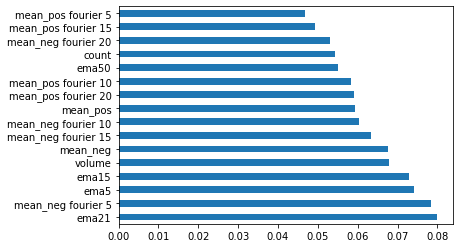

In [819]:
feat_imp = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_imp.nlargest(100).plot(kind='barh')
plt.show()

### Selected features

In [820]:
rf_sfm = SelectFromModel(rf_clf)

rf_sfm = rf_sfm.fit(X_train, y_train.values.ravel())

In [821]:
X_important_train = rf_sfm.transform(X_train)
X_important_test = rf_sfm.transform(X_test)

In [822]:
clf_important = RandomForestClassifier(n_estimators=20000, random_state=1, n_jobs=-1)

clf_important = clf_important.fit(X_important_train, y_train.values.ravel())

In [823]:
y_important_pred = clf_important.predict(X_important_test)
print('Selected features Acc = ', accuracy_score(y_test, y_important_pred))
print('Selected features f1 score = ', f1_score(y_test, y_important_pred))

Selected features Acc =  0.6190476190476191
Selected features f1 score =  0.42857142857142855


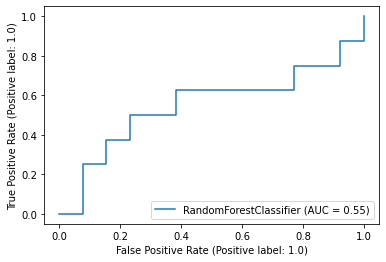

In [824]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf_important, X_important_test, y_test, ax=ax)
plt.show()

In [825]:
## live prediction - 0

live_pred_transform = rf_sfm.transform(live_pred_data)
live_pred = clf_important.predict(live_pred_transform)
live_pred

array([1.])

## **Logistic-Random Forest Pipeline Model**

In [826]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression(penalty="l2", random_state=1, solver='sag', max_iter=10000, n_jobs=-1))),
  ('classification', RandomForestClassifier(criterion='entropy', n_estimators=20000, random_state=1, n_jobs = -1))
])
clf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(max_iter=10000,
                                                              n_jobs=-1,
                                                              random_state=1,
                                                              solver='sag'))),
                ('classification',
                 RandomForestClassifier(criterion='entropy', n_estimators=20000,
                                        n_jobs=-1, random_state=1))])

In [827]:
y_pred = clf.predict(X_test)
print('Acc = ', accuracy_score(y_test, y_pred))
print('f1 score = ', f1_score(y_test, y_pred))

Acc =  0.5238095238095238
f1 score =  0.5


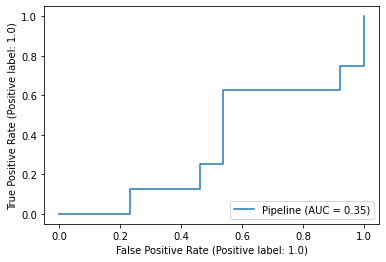

In [828]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax)
plt.show()

In [829]:
## live prediction - 0

clf.predict(live_pred_data)

array([1.])

# SKTime Algorithms

## Shapelet Transform

In [830]:
# How long (in minutes) to extract shapelets for.
# This is a simple lower-bound initially;
# once time is up, no further shapelets will be assessed
time_contract_in_mins = 3


In [831]:
# The initial number of shapelet candidates to assess per training series.
# If all series are visited and time remains on the contract then another
# pass of the data will occur
initial_num_shapelets_per_case = 10

In [832]:
# Whether or not to print on-going information about shapelet extraction.
# Useful for demo/debugging
verbose = 0

In [833]:
pipeline = Pipeline(
    [
        (
            "st",
            ContractedShapeletTransform(
                time_contract_in_mins=time_contract_in_mins,
                num_candidates_to_sample_per_case=10,
                verbose=verbose,
            ),
        ),
        ("rf", RandomForestClassifier(n_estimators=100)),
    ]
)


Accuracy: 0.6190476190476191 
 f1_score: 0.5


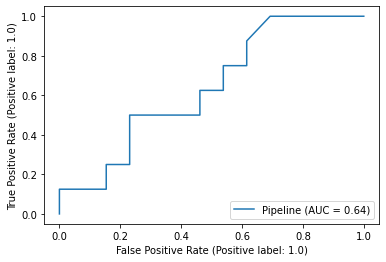

In [834]:

pipeline.fit(from_2d_array_to_nested(X_train), y_train.values.ravel())
y_pred = pipeline.predict(from_2d_array_to_nested(X_test))

print(f'Accuracy: {accuracy_score(y_test,y_pred)} \n f1_score: {f1_score(y_test, y_pred)}')
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(pipeline, from_2d_array_to_nested(X_test), y_test.values.ravel(), ax=ax)
plt.show()

In [835]:
## live prediction - 0

live_pred = pipeline.predict(from_2d_array_to_nested(live_pred_data))
live_pred

array([0.])

## **Time Series Forest Classifier**

In [836]:
steps = [(
        "extract",
        RandomIntervalFeatureExtractor(n_intervals="sqrt", min_length=5, random_state=1, features=[np.mean, np.std, _slope]),),
        ("clf", DecisionTreeClassifier(criterion='entropy')),]
time_series_tree = Pipeline(steps)

In [837]:
time_series_tree.fit(from_2d_array_to_nested(X_train), y_train.values.ravel())
time_series_tree.score(from_2d_array_to_nested(X_test), y_test.values.ravel())

0.6190476190476191

In [838]:
tsf = ComposableTimeSeriesForestClassifier(
    estimator=time_series_tree,
    n_estimators=20000,
    bootstrap=True,
    random_state=1,
    n_jobs=-1,
)

In [839]:
tsf.fit(from_2d_array_to_nested(X_train), y_train.values.ravel())

ComposableTimeSeriesForestClassifier(bootstrap=True,
                                     estimator=Pipeline(steps=[('extract',
                                                                RandomIntervalFeatureExtractor(features=[<function mean at 0x000001B76B9B6CA0>,
                                                                                                         <function std at 0x000001B76B9B6E50>,
                                                                                                         <function _slope at 0x000001B773A1DCA0>],
                                                                                               min_length=5,
                                                                                               random_state=1)),
                                                               ('clf',
                                                                DecisionTreeClassifier(criterion='entropy'))]),
                                 

In [840]:
y_pred = tsf.predict(from_2d_array_to_nested(X_test))

In [841]:
print(f'Accuracy: {accuracy_score(y_test,y_pred)} \n f1_score: {f1_score(y_test, y_pred)}')

Accuracy: 0.5238095238095238 
 f1_score: 0.28571428571428575


In [842]:
# live prediction - 0

live_pred = tsf.predict(from_2d_array_to_nested(live_pred_data))
live_pred

array([0.])